![Image of Yaktocat](sendy.jpg)

# Sendy Logistics Regression Model
<br></br>


## Introduction

Sendy is a business-to-business platform established in 2014, to enable businesses of all types and sizes to transport goods more efficiently across East Africa.

Logistics is fundamental to the success of a business while efficient and affordable logistics are a vital component of economic development. To help Sendy achieve affordability and effieciency, a prediction of the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination is made. This prediction will enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience.

The prediction will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling. The accurate arrival time prediction will help all businesses involved to improve their logistics and communicate an accurate time to their customers.

## Importing the Libraries

In [1]:
import numpy as np 
import math
# data processing
import pandas as pd 

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import tree
from sklearn.model_selection import GridSearchCV

C:\Users\ELTON\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Getting the Data

In [49]:
# the csv files are converted to panda dataframe and are renamed.
Train_df= pd.read_csv("Train.csv")
Test_df= pd.read_csv("Test.csv")
Riders_df= pd.read_csv("Riders.csv")
VariableDefinitions_df= pd.read_csv("VariableDefinitions.csv")
SampleSubmission_df= pd.read_csv("SampleSubmission.csv")


## Data Description

Exploring data sets helps in developing deep understanding about the data, the data set is Explored with imported libraries.The Variable dataframe below displays the name of features and desciptions on the right.

In [3]:
VariableDefinitions_df

,Order No,Unique number identifying the order
0,User Id,Unique number identifying the customer on a pl...
1,Vehicle Type,"For this competition limited to bikes, however..."
2,Platform Type,"Platform used to place the order, there are 4 ..."
3,Personal or Business,Customer type
4,Placement - Day of Month,Placement - Day of Month i.e 1-31
5,Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
6,Placement - Time,Placement - Time - Time of day the order was p...
7,Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
8,Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)
9,Confirmation - Time,Confirmation - Time - Time of day the order wa...


The dataframe above is the list of the features with a short description:

In [4]:
VariableDefinitions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Order No                             34 non-null     object
 1   Unique number identifying the order  33 non-null     object
dtypes: object(2)
memory usage: 688.0+ bytes


In [5]:
#Train data set
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

The training-set has 21201 entries and 28 features + the target variable (Time from Pickup to Arrival). 6 of the features are floats, 13 are integers and 10 are objects.Since there is a Train data set, this implies that the data has been split and any aditing that will be done on the train data set will also be applied on the Test data set.

In [6]:
Train_df.head(8)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214
5,Order_No_7408,User_Id_1342,Bike,3,Business,14,5,3:07:35 PM,14,5,...,4:23:41 PM,9,27.2,NaN,-1.302583,36.767081,-1.257309,36.806008,Rider_Id_124,3191
6,Order_No_22680,User_Id_2803,Bike,3,Business,9,5,9:33:45 AM,9,5,...,10:19:45 AM,5,20.3,NaN,-1.279395,36.825364,-1.276574,36.851365,Rider_Id_114,1380
7,Order_No_21578,User_Id_1075,Bike,3,Business,11,1,2:13:01 PM,11,1,...,2:33:26 PM,3,28.7,NaN,-1.252796,36.800313,-1.255189,36.782203,Rider_Id_913,646


From the table above,few things can be noted. some of the features need to be converted into numeric ones, so that the machine learning algorithms can process them. Furthermore. Some more features, that contain missing values (NaN = not a number) can also be spoted, that would be deal with later on.

In [7]:
Train_df.columns.values

array(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)',
       'Pickup - Time', 'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'], dtype=object)

Above are all features present in the Train data frame

In [9]:
    # Rider data set
Riders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rider Id        960 non-null    object 
 1   No_Of_Orders    960 non-null    int64  
 2   Age             960 non-null    int64  
 3   Average_Rating  960 non-null    float64
 4   No_of_Ratings   960 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 37.6+ KB


Rider_df displays the information about the motorbike riders. It consist of 5 features and 960 entries.

In [10]:
Riders_df.head(8)

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156
5,Rider_Id_720,2608,1798,13.2,504
6,Rider_Id_95,3464,1304,13.4,950
7,Rider_Id_122,4831,2124,14.1,1469


Above is the overview of the Riders data frame. The feature (Rider Id) is common to both Riders and Train Data Frame this allows for a merge between the two data frames.

In [11]:
#features found within the Rider data set.
Riders_df.columns.values

array(['Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings'], dtype=object)

In [12]:
    #a look at the submission sample data frame
SampleSubmission_df.head(8)

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,567.0
1,Order_No_12736,4903.0
2,Order_No_768,5649.0
3,Order_No_15332,NaN
4,Order_No_21373,NaN
5,Order_No_14573,NaN
6,Order_No_6731,NaN
7,Order_No_18436,NaN


The sample submission displays the format in which sumbmision would be made for this predict on Zindi

## Data cleaning and formating

#### __Data cleaning__

In [50]:
    #Joining the riders to both Train and Test data set
Train_df = pd.merge(Train_df, Riders_df, left_on='Rider Id', 
                    right_on='Rider Id', how='left')
Test_df = pd.merge(Train_df, Riders_df, left_on='Rider Id',
                    right_on='Rider Id', how='left')

Test and Train data frames are merged with Riders data data frame on the Rider Id feature.

In [14]:
Train_df.head(8)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533
5,Order_No_7408,User_Id_1342,Bike,3,Business,14,5,3:07:35 PM,14,5,...,-1.302583,36.767081,-1.257309,36.806008,Rider_Id_124,3191,3288,1204,14.2,1056
6,Order_No_22680,User_Id_2803,Bike,3,Business,9,5,9:33:45 AM,9,5,...,-1.279395,36.825364,-1.276574,36.851365,Rider_Id_114,1380,288,556,13.7,27
7,Order_No_21578,User_Id_1075,Bike,3,Business,11,1,2:13:01 PM,11,1,...,-1.252796,36.800313,-1.255189,36.782203,Rider_Id_913,646,4036,2119,14.4,700


Above is the new merged Train data set and The same is be done for the Test data set. For the purpose of this predict, the Vehicle Type feature is dropped because only motor bikes are considered. The naming format is not consistant in the above data frame(under scores will be use instead of spaces)

In [51]:
    # Dropin the  Vehicle Type 
Train_df = Train_df.drop(['Vehicle Type'], axis = 1)
Test_df = Test_df.drop(['Vehicle Type'], axis = 1)

In [17]:
Test_df.head(8)

,Order No,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,...,Rider Id,Time from Pickup to Arrival,No_Of_Orders_x,Age_x,Average_Rating_x,No_of_Ratings_x,No_Of_Orders_y,Age_y,Average_Rating_y,No_of_Ratings_y
0,Order_No_4211,User_Id_633,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,...,Rider_Id_432,745,1637,1309,13.8,549,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,...,Rider_Id_856,1993,396,339,13.6,69,396,339,13.6,69
2,Order_No_1899,User_Id_265,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,...,Rider_Id_155,455,1023,242,12.5,114,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,...,Rider_Id_855,1341,886,283,14.5,113,886,283,14.5,113
4,Order_No_27883,User_Id_1737,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,...,Rider_Id_770,1214,2311,872,14.1,533,2311,872,14.1,533
5,Order_No_7408,User_Id_1342,3,Business,14,5,3:07:35 PM,14,5,3:08:57 PM,...,Rider_Id_124,3191,3288,1204,14.2,1056,3288,1204,14.2,1056
6,Order_No_22680,User_Id_2803,3,Business,9,5,9:33:45 AM,9,5,9:49:47 AM,...,Rider_Id_114,1380,288,556,13.7,27,288,556,13.7,27
7,Order_No_21578,User_Id_1075,3,Business,11,1,2:13:01 PM,11,1,2:14:13 PM,...,Rider_Id_913,646,4036,2119,14.4,700,4036,2119,14.4,700


In [52]:
Test_df.head(8)

,Order No,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,...,Rider Id,Time from Pickup to Arrival,No_Of_Orders_x,Age_x,Average_Rating_x,No_of_Ratings_x,No_Of_Orders_y,Age_y,Average_Rating_y,No_of_Ratings_y
0,Order_No_4211,User_Id_633,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,...,Rider_Id_432,745,1637,1309,13.8,549,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,...,Rider_Id_856,1993,396,339,13.6,69,396,339,13.6,69
2,Order_No_1899,User_Id_265,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,...,Rider_Id_155,455,1023,242,12.5,114,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,...,Rider_Id_855,1341,886,283,14.5,113,886,283,14.5,113
4,Order_No_27883,User_Id_1737,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,...,Rider_Id_770,1214,2311,872,14.1,533,2311,872,14.1,533
5,Order_No_7408,User_Id_1342,3,Business,14,5,3:07:35 PM,14,5,3:08:57 PM,...,Rider_Id_124,3191,3288,1204,14.2,1056,3288,1204,14.2,1056
6,Order_No_22680,User_Id_2803,3,Business,9,5,9:33:45 AM,9,5,9:49:47 AM,...,Rider_Id_114,1380,288,556,13.7,27,288,556,13.7,27
7,Order_No_21578,User_Id_1075,3,Business,11,1,2:13:01 PM,11,1,2:14:13 PM,...,Rider_Id_913,646,4036,2119,14.4,700,4036,2119,14.4,700


The Vehicle feature has been succefully droped from both data frames.

In [53]:
    # Formatting the naming of the columns
Train_df.columns = Train_df.columns.str.replace(' ', '_')
Test_df.columns = Test_df .columns.str.replace(' ', '_')

In [54]:
    #removing "-" from the feature labels.
Train_df.columns = Train_df.columns.str.replace('_-_', '_')
Train_df = Train_df.rename(columns={"Time_from_Pickup_to_Arrival": "Time from Pickup to Arrival"})
Test_df.columns = Test_df .columns.str.replace('_-_', '_')
Test_df = Test_df.rename(columns={"Time_from_Pickup_to_Arrival": "Time from Pickup to Arrival"})

In [22]:
Train_df.head(8)

,Order_No,User_Id,Platform_Type,Personal_or_Business,Placement_Day_of_Month,Placement_Weekday_(Mo_=_1),Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_(Mo_=_1),Confirmation_Time,...,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533
5,Order_No_7408,User_Id_1342,3,Business,14,5,3:07:35 PM,14,5,3:08:57 PM,...,-1.302583,36.767081,-1.257309,36.806008,Rider_Id_124,3191,3288,1204,14.2,1056
6,Order_No_22680,User_Id_2803,3,Business,9,5,9:33:45 AM,9,5,9:49:47 AM,...,-1.279395,36.825364,-1.276574,36.851365,Rider_Id_114,1380,288,556,13.7,27
7,Order_No_21578,User_Id_1075,3,Business,11,1,2:13:01 PM,11,1,2:14:13 PM,...,-1.252796,36.800313,-1.255189,36.782203,Rider_Id_913,646,4036,2119,14.4,700


In [55]:
print('There are', Train_df['Rider_Id'].nunique(), 
      'Motorbike riders', 'and', Train_df['User_Id'].nunique(), 
      'Customers')

There are 924 Motorbike riders and 3186 Customers


__Handling missing data__

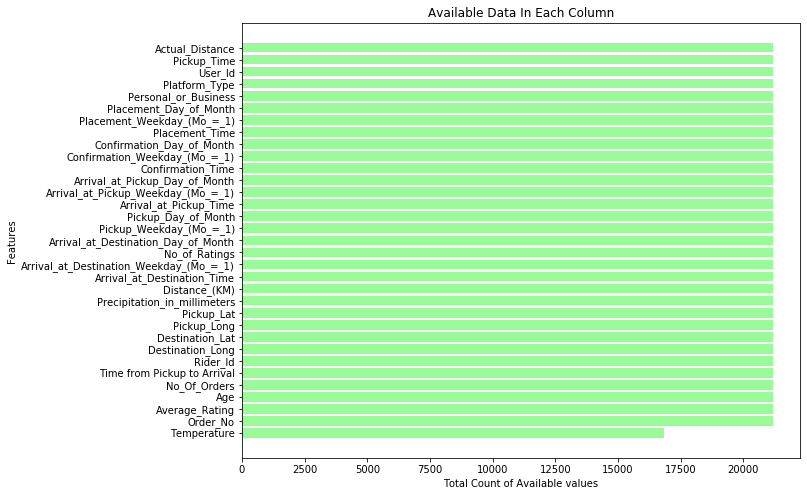

In [120]:
aval_df = Train_df.notnull().sum(axis=0).reset_index()
aval_df.columns = ['column_name', 'missing_count']
aval_df = aval_df.loc[aval_df['missing_count']>0]
aval_df = aval_df.sort_values(by='missing_count')

ind = np.arange(aval_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,8))
rects = ax.barh(ind, aval_df.missing_count.values, color='palegreen')
ax.set_yticks(ind)
ax.set_yticklabels(aval_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Total Count of Available values")
ax.set_ylabel("Features")
ax.set_title("Available Data In Each Column")
plt.show()

__More detailed look at what data is actually missing:__

In [56]:
 #Train_df missing data
total = Train_df.isnull().sum().sort_values(ascending=False)
percent_1 = Train_df.isnull().sum()/Train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Precipitation_in_millimeters,20649,97.4
Temperature,4366,20.6
No_of_Ratings,0,0.0
Confirmation_Weekday_(Mo_=_1),0,0.0
Arrival_at_Pickup_Time,0,0.0


Text(0, 0.5, 'Features')

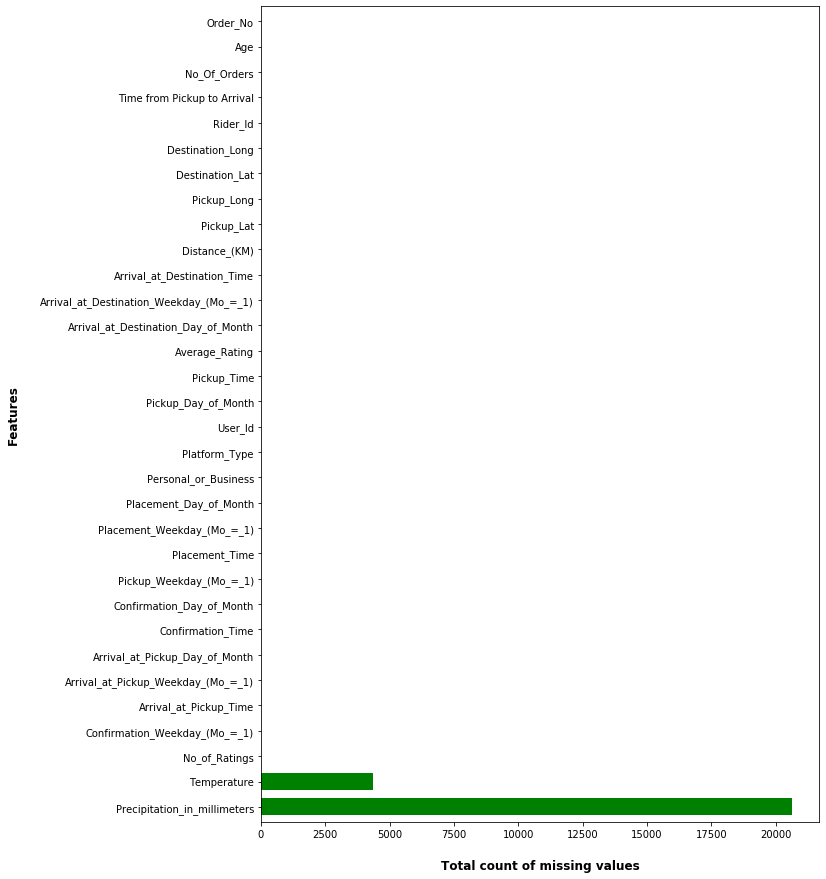

In [57]:
 #Visual Display of missing Data in Train data frame
ax = missing_data['Total'].plot(kind='barh', figsize=(10, 15), color='lightred', zorder=2, width=0.68)
ax.set_title("Total Count of Missing Data in Features",  labelpad=24, weight='bold', size=18)
ax.set_xlabel("Total count of missing values", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Features", labelpad=20, weight='bold', size=12)


As obseved from both missing_data frame and the visual display above, it will be a bit tricky to deal with the 'Temparature' feature, which has 4366 missing values. However on the other hand, the 'Precipitation in mm' feature needs further investigation, but it looks like it would be better if it is dropped off from the dataset, since 97.4 % of it is missing data.

*Investigating on Precipitation in millimeter feature.*

In [67]:
    #Checking if there are 0 mm records of Precipitation from both Test and Train data frame
(Train_df['Precipitation_in_millimeters']==0).all(),(Test_df['Precipitation_in_millimeters']==0).all()


(False, False)

The are no Recorded 0 values for precipitation in both of the data frames. It is not likely that pricipitation may occur in all days of the month. So it makes sense that 97% of the time in a month there is no precipitation, therefore the NaN values will be replaced with 0 values.Meaning on those days there was no precipitation.

In [102]:
    #replacing NAN with 0 for precipitation feature
Train_df["Precipitation_in_millimeters"] = Train_df["Precipitation_in_millimeters"].fillna(0)
Test_df["Precipitation_in_millimeters"] = Test_df["Precipitation_in_millimeters"].fillna(0)

In [103]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Order_No                                 21201 non-null  object 
 1   User_Id                                  21201 non-null  object 
 2   Platform_Type                            21201 non-null  int64  
 3   Personal_or_Business                     21201 non-null  object 
 4   Placement_Day_of_Month                   21201 non-null  int64  
 5   Placement_Weekday_(Mo_=_1)               21201 non-null  int64  
 6   Placement_Time                           21201 non-null  object 
 7   Confirmation_Day_of_Month                21201 non-null  int64  
 8   Confirmation_Weekday_(Mo_=_1)            21201 non-null  int64  
 9   Confirmation_Time                        21201 non-null  object 
 10  Arrival_at_Pickup_Day_of_Month           21201

checking from the infomation above, temparature is the only feature with missing values.

Checking for correlation between Temparature and features which may have influence of Time from Pickup to Arrival

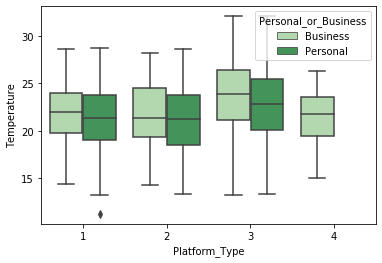

In [100]:
    #Train_df data set 
Temp = sns.boxplot(x="Platform_Type", y="Temperature", hue="Personal_or_Business",
                 data=Train_df, palette="Greens")


The whisker and the box diagram propose that there is a relationship between the temparature and the platform as well as the Personal or bussiness feature. Below is the function, conditional_impute, which performs imputation upon Temperature column within a Pandas DataFrame based upon both Personal or Business and platform.

Data imputation-----------

__*Data formating*__

The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.Below is the fuction that will calculate the disdance between the pickup and destination location.

In [106]:
def haversine_vectorize(lon1, lat1, lon2, lat2): 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) 
    newlon = lon2 - lon1
    newlat = lat2 - lat1 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM(radius of the Earth)
    return round(km, 0)

In [109]:
distance_1 = haversine_vectorize(Train_df['Pickup_Lat'], 
                               Train_df['Pickup_Long'], 
                               Train_df['Destination_Lat'], 
                               Train_df['Destination_Long'])
Train_df['Actual_Distance'] = distance_1
distance_2 = haversine_vectorize(Train_df['Pickup_Lat'], 
                               Train_df['Pickup_Long'], 
                               Train_df['Destination_Lat'], 
                               Train_df['Destination_Long'])
Test_df['Actual_Distance'] = distance_2

In [110]:
Train_df.head(5)

,Order_No,User_Id,Platform_Type,Personal_or_Business,Placement_Day_of_Month,Placement_Weekday_(Mo_=_1),Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_(Mo_=_1),Confirmation_Time,...,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Actual_Distance
0,Order_No_4211,User_Id_633,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,...,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549,2.0
1,Order_No_25375,User_Id_2285,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,...,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69,11.0
2,Order_No_1899,User_Id_265,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,...,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114,2.0
3,Order_No_9336,User_Id_1402,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,...,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113,5.0
4,Order_No_27883,User_Id_1737,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,...,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533,3.0


In [ ]:
    # Droping coordinate features


# EDA

Exploring the features in the data frame

### A first look at the behaviour of delivery time (Y - Variable)

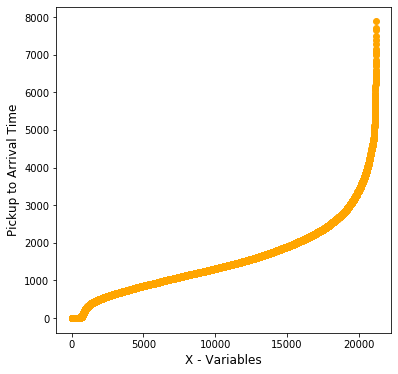

In [123]:
plt.figure(figsize=(6,6))
plt.scatter(range(Train_df.shape[0]), np.sort(Train_df['Time from Pickup to Arrival'].values), 
            color = 'orange')
plt.xlabel('X - Variables', fontsize=12)
plt.ylabel('Pickup to Arrival Time', fontsize=12)
plt.show()

 ## *Thasamy will add interpretation*

We are going to look at the Platform Type and Business type to look at what makes up most of the orders.

We are looking at the User Id feature to check the number of users we going to be working with. This is done by getting the number of unique values in the User Id column.

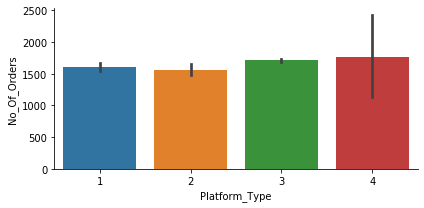

In [151]:
Platform_type = sns.factorplot(y="No_Of_Orders", x ="Platform_Type", 
                          size=3, kind='bar', aspect=2, data=Train_df)

In [126]:
#interpretation

Personal of Business

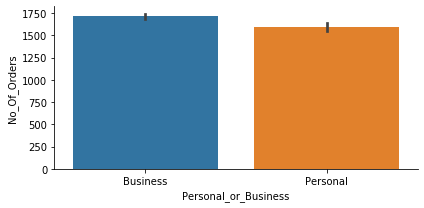

In [154]:
Personal_bussiness = sns.factorplot(y="No_Of_Orders", x ="Personal_or_Business", 
                          size=3, kind='bar', aspect=2, data=Train_df)

In [164]:
labels = ['Business', 'Personal']
sizes = [Train_df['Personal_or_Business'].value_counts(),
         Train_df['No_Of_Orders'].value_counts()        
# print(sizes) # adds up to 1433, which is the total number of participants
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

SyntaxError: invalid syntax (<ipython-input-164-3eb8849e5d8e>, line 5)

### Placement and confirmation Day of the month

In [160]:
num_bins = 10
Train_df.barplot(column='Placement_Day_of_Month',bins=4,grid=False,figsize=(10,5),edgecolor='black')
plt.xlabel('Day_of_the_month')
plt.ylabel('Number_Of_orders')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'barplot'

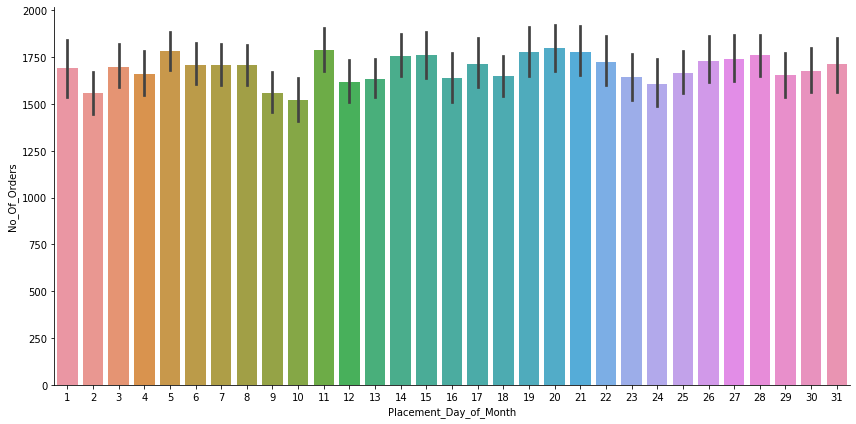

In [147]:
Pacement = sns.factorplot(y="No_Of_Orders", x ="Placement_Day_of_Month", 
                          size=6, kind='bar', aspect=2, data=Train_df)

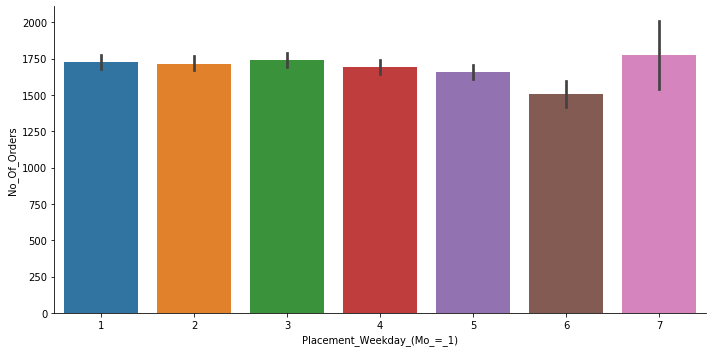

In [146]:
Pacement_week = sns.factorplot(y="No_Of_Orders", x ="Placement_Weekday_(Mo_=_1)", 
                          size=5, kind='bar', aspect=2, data=Train_df)